Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


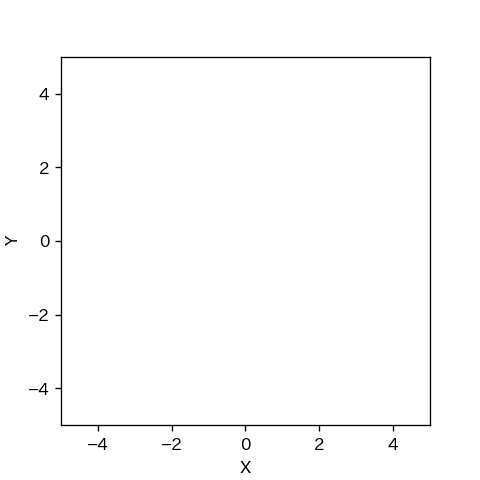

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import *

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): #追加
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
            
        
        
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold: 
            self.sensor_resetting(observation) #sensor_resettingに変更
        else:
            self.resampling() 

In [3]:
def trial_kidnap(animation): ###mclkidnap1test
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-2,-2))
    m.append_landmark(Landmark(2,-2))
    m.append_landmark(Landmark(0,2*math.sqrt(3)-2))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    robot_pose=np.array([np.random.uniform(-2.0,2.0),np.random.uniform(-2.0,2*math.sqrt(3)-2),np.random.uniform(-math.pi,math.pi)]).T
    pf = ResetMcl(m, init_pose, 100)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()
    
    return (r.pose, pf.ml.pose)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>


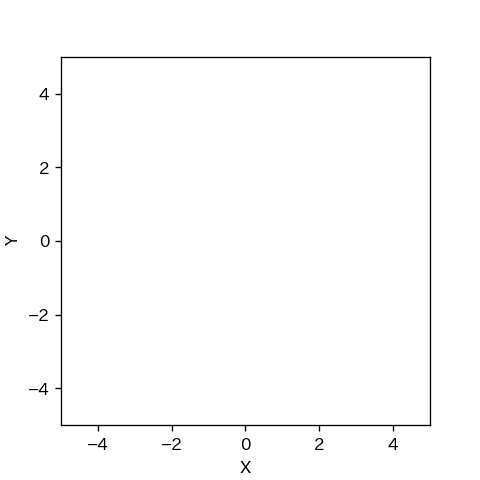

(array([-1.27211269, -0.63758921, -2.57024449]),
 array([ 0.73078419,  2.12739757, -3.10956209]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

0 真値: [-2.32392596 -0.98365177  6.86057993] 推定値: [-2.82772677 -1.10036918  0.58388671] 誤差: 0.5171442826119768
1
1 真値: [-1.03825688  1.63241528  4.60674878] 推定値: [-0.39712843  1.48773836  4.42124543] 誤差: 0.6572496502213905
2
2 真値: [ 1.53564616 -0.27933488  3.07437089] 推定値: [1.22709469 0.03917839 3.17201415] 誤差: 0.44345767470689856
3
3 真値: [-1.43728272 -0.18318242  7.84665263] 推定値: [-1.39136579 -0.16869963  1.55533654] 誤差: 0.04814681810014067
4
4 真値: [ 1.71586364 -0.71022807  3.15108708] 推定値: [ 1.93056252 -1.071366    3.04770597] 誤差: 0.42013832864186845
5
5 真値: [-2.45675309  0.1931338   6.18746913] 推定値: [-2.34687461  0.0401927   6.12891781] 誤差: 0.1883195656988212
6
6 真値: [0.12076787 0.26567767 7.01248405] 推定値: [0.1746475  0.33030874 0.78094967] 誤差: 0.08414386724015609
7
7 真値: [ 0.93413838 -1.87698176  7.79120655] 推定値: [ 0.96831606 -1.75531173  1.55010994] 誤差: 0.12637923301858636
8
8 真値: [-3.40723121 -1.76525534  5.58693287] 推定値: [-3.74951843 -1.74990361 -0.73426727] 誤差: 0.342631314413258

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [-0.17401685  1.43108545  3.44112191] 推定値: [-0.52385834  1.40065744  3.5041082 ] 誤差: 0.3511622578757586
20
21 真値: [-1.93676094  0.33206952  4.7263711 ] 推定値: [-2.34932199 -0.33501296 -1.37328456] 誤差: 0.7843504731189825
21
22 真値: [ 1.99755715 -1.02135854  3.14050619] 推定値: [ 1.44736641 -1.6987514   2.90512701] 誤差: 0.8726803209195855
22
23 真値: [-1.56189413  2.61932661  4.1361002 ] 推定値: [ 2.35114102 -4.71074955  8.32763888] 誤差: 8.309143192440887
24 真値: [-0.44179537 -0.04212992  2.59169796] 推定値: [-0.33921741 -0.03985891  2.57879669] 誤差: 0.10260308996434177
23
25 真値: [-1.04941359 -0.55232435  4.47693634] 推定値: [-1.25129854 -0.58641353  4.58444498] 誤差: 0.20474277267629648
24
26 真値: [ 1.57319392 -3.07800633  7.00965559] 推定値: [ 1.49904717 -3.09750863  6.86068747] 誤差: 0.07666864081385269
25
27 真値: [-1.92783227 -1.31787784  5.74884518] 推定値: [-1.92644966 -1.33976428  5.65635416] 誤差: 0.02193006482207751
26
28 真値: [ 2.09854108 -0.61055168  7.66422592] 推定値: [ 2.26833333 -0.73869867  7.58732423] 